## This notebook is used to conduct ACS data extraction using census API, yearly data interpolation, PGIM data merging, and OLS model building.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import censusdata
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Set your Census API key as an environment variable
os.environ["CENSUS_API_KEY"] = "d6a829e3229193acd4e98d0f4ad90540cdfe59d5"

In [ ]:
## get state fips from zipcode
from uszipcode import SearchEngine
def get_state_fips(zipcode):
    search = SearchEngine()
    zipcode_info = search.by_zipcode(zipcode)

    state_abbr = zipcode_info.state

    state_to_fips = {
        'AK': '02', 'AL': '01', 'AR': '05', 'AS': '60', 'AZ': '04', 'CA': '06', 'CO': '08', 'CT': '09', 
        'DC': '11', 'DE': '10', 'FL': '12', 'GA': '13', 'GU': '66', 'HI': '15', 'IA': '19', 'ID': '16', 
        'IL': '17', 'IN': '18', 'KS': '20', 'KY': '21', 'LA': '22', 'MA': '25', 'MD': '24', 'ME': '23', 
        'MI': '26', 'MN': '27', 'MO': '29', 'MS': '28', 'MT': '30', 'NC': '37', 'ND': '38', 'NE': '31', 
        'NH': '33', 'NJ': '34', 'NM': '35', 'NV': '32', 'NY': '36', 'OH': '39', 'OK': '40', 'OR': '41', 
        'PA': '42', 'PR': '72', 'RI': '44', 'SC': '45', 'SD': '46', 'TN': '47', 'TX': '48', 'UT': '49', 
        'VA': '51', 'VI': '78', 'VT': '50', 'WA': '53', 'WI': '55', 'WV': '54', 'WY': '56'
    }

    state_fips = state_to_fips.get(state_abbr)

    return state_fips

In [16]:
pgim_all = pd.read_csv('data/processed_data/pgim_erent_all.csv')

In [23]:
pgim_all['zip'] = pgim_all['Zip Code'].astype(str).str.zfill(5)

In [86]:
variables = {'index': 'zip',
'B01003_001E': 'Total Population',
'B25001_001E': 'Total Housing',
'B19013_001E': 'Median Household Income (USD)',
'B01002_001E': 'Median Age',
'B15003_022E': 'Bachelor degree',
'B06009_006E': 'Graduate or Professional Degree',
'B23025_005E': 'Unemployment Labor Force',
'B23025_003E': 'Labor Force',
'B25064_001E': 'Median Gross Rent',
'B11001_001E': 'Number of Households',
'B02001_002E': 'population (white)',
'B17001_002E' : 'Below Poverty',
'B25002_003E': 'Renter-occupied housing units',
'B08013_001E': 'Aggregate travel time to work (in minutes)'
    }

In [87]:
zipcodes = pgim_all['zip'].unique()

In [91]:
def local_census_data(year,state,zipcode, variables):
    lst = [i for i in variables.keys() if i != 'index']
    zipcode = censusdata.censusgeo([('state', state), ('zip code tabulation area', zipcode)])
    acs_county = censusdata.download('acs5', year, zipcode,lst
                    ,key='d6a829e3229193acd4e98d0f4ad90540cdfe59d5')
    acs_county = acs_county.reset_index()
    acs_county = acs_county.rename(columns=variables)

    acs_county ['Percent of Bachelor degree'] = (acs_county['Bachelor degree']+acs_county['Graduate or Professional Degree'])/acs_county['Total Population']
    acs_county['Poverty Rate'] = acs_county['Below Poverty'] / acs_county['Total Population']
    acs_county['Percent of white alone'] = acs_county['population (white)'] / acs_county['Total Population']
    acs_county['Unemployment Rate'] = acs_county['Unemployment Labor Force'] / acs_county['Labor Force'] 

    acs_county['Percentage of Rent'] = acs_county['Renter-occupied housing units']/acs_county['Total Housing']
    acs_county['Households per person'] = acs_county['Number of Households']/acs_county['Total Population']
    acs_county['Average travel time to work'] = acs_county['Aggregate travel time to work (in minutes)']/acs_county['Total Population'] 
    acs_county['Housing per person'] = acs_county['Total Housing']/acs_county['Total Population']  

    acs_county['zip'] = acs_county['zip'].astype(str)
    acs_county['zip'] = acs_county['zip'].apply(lambda x: str(x).split(">")[-1].split(":")[1].strip() 
                                                                if isinstance(x, str) else x.tract.split(":")[-1].strip())
    acs_county['Year'] = year

    acs_county.drop(['Bachelor degree','Graduate or Professional Degree', 'Below Poverty','Aggregate travel time to work (in minutes)',
                      'population (white)','Number of Households','Unemployment Labor Force','Labor Force', 'Renter-occupied housing units'],axis=1,inplace=True)
 
    acs_county = acs_county.sort_values(by = ['zip'], ignore_index = True)
    return acs_county

In [92]:
local_census_data(2019,get_state_fips(zipcodes[33]),zipcodes[33], variables)

,zip,Total Population,Total Housing,Median Household Income (USD),Median Age,Median Gross Rent,Percent of Bachelor degree,Poverty Rate,Percent of white alone,Unemployment Rate,Percentage of Rent,Households per person,Average travel time to work,Housing per person,Year
0,75241,31562,11963,32313,34.0,931,0.068057,0.291617,0.201128,0.065201,0.078743,0.349186,11.004372,0.379032,2019


In [93]:
# Concatenatea
acs_all = pd.DataFrame()
for year in range(2011, 2020):
    for zipcode in zipcodes:
        state = get_state_fips(zipcode)
        try:
            acs_county = local_census_data(year,state, zipcode,variables)
            acs_all = pd.concat([acs_all, acs_county], ignore_index=True)
        except Exception:
            pass

In [96]:
## missing zipcodes
[i for i in pgim_all.zip.unique() if i not in acs_all.zip.unique()]

['75033', '75036']

In [98]:
acs_all.to_csv('data/processed_data/acs_all.csv',index=False)

In [237]:
acs_all = pd.read_csv('data/processed_data/acs_all.cs')

In [238]:
acs_all.rename(columns={'zip':'Zip Code'},inplace=True)

In [239]:
acs_all

,Zip Code,Total Population,Total Housing,Median Household Income (USD),Median Age,Median Gross Rent,Percent of Bachelor degree,Poverty Rate,Percent of white alone,Unemployment Rate,Percentage of Rent,Households per person,Average travel time to work,Housing per person,Year
0,30312,18060,11691,44379,33.2,948,0.374806,0.271262,0.426301,0.100292,0.191686,0.523256,12.260244,0.647342,2012
1,30324,25695,15301,61914,33.3,1063,0.464409,0.140261,0.675268,0.080988,0.122280,0.522670,14.589803,0.595486,2012
2,30318,54248,25218,39097,29.3,918,0.239990,0.314519,0.326593,0.159753,0.226307,0.359663,10.364990,0.464865,2012
3,30319,36148,18219,85263,35.8,1158,0.499751,0.108581,0.794871,0.048390,0.087381,0.459970,12.358360,0.504011,2012
4,30317,11520,6367,48488,37.2,995,0.320486,0.175868,0.411979,0.097165,0.205120,0.439323,13.851562,0.552691,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,94123,25890,15013,162206,34.0,2506,0.713673,0.043067,0.833411,0.027958,0.082862,0.531827,20.578602,0.579876,2019
3740,94158,8455,5114,156856,34.4,3035,0.605204,0.127853,0.490952,0.022843,0.127689,0.527617,20.826138,0.604849,2019
3741,94025,43392,16365,161827,38.3,2346,0.464602,0.071511,0.694621,0.037530,0.076932,0.348129,11.890325,0.377143,2019
3742,94065,12461,5275,172663,42.1,3396,0.554610,0.046706,0.448921,0.046379,0.014787,0.417061,15.776824,0.423321,2019


In [240]:
acs_all = acs_all[acs_all['Median Household Income (USD)']>=0]

### Interpolation

In [241]:
import pandas as pd
import numpy as np
## Create DF

df = (pd
        .DataFrame( index= pd.date_range( '2010-01-01', '2019-12-31' ,freq='3MS'))
      .reset_index()
      .rename(columns={'index' : 'y_dt'})
      .assign(key=1)
     )

## load data from Jennifer
df_to_merge = acs_all

df_census_tract = df_to_merge.loc[:, ['Zip Code']].drop_duplicates().assign(key=1)

df = pd.merge( df, df_census_tract, how='outer', on='key').drop(['key'], axis=1)

assert df_to_merge.shape[0] == df_to_merge.loc[:, ['Zip Code', 'Year']].drop_duplicates().shape[0]

## Deal with assert
df_to_merge.loc[:, 'y_dt'] = pd.to_datetime(df_to_merge['Year'], format='%Y')
df_to_merge = df_to_merge.sort_values('y_dt')

df_to_merge.head()
merged_df = pd.merge( df, df_to_merge, how='left', on = ['y_dt', 'Zip Code'])

cols = [i for i in acs_all.columns if i not in ['Year','y_dt','Zip Code']]

In [242]:
merged_df = merged_df.sort_values(['Zip Code', 'y_dt'])

new_df = merged_df.copy()
new_df.loc[:, 'new_col'] = np.nan

for census_tract in merged_df.loc[:, 'Zip Code'].unique():

    merged_df = merged_df.sort_values(['Zip Code', 'y_dt'])

    for col in cols:
        temp_df = (merged_df.loc[(merged_df.loc[:, 'Zip Code'] == census_tract), [col]]
                    .interpolate(method = "spline", order = 1,  limit_direction = "both",  downcast = "infer")
                    .interpolate(method='bfill')
                    .reset_index(drop=True))
        
        new_df.loc[(new_df.loc[:, 'Zip Code'] == census_tract), f'Quarterly {col}'] = temp_df.values


In [243]:
new_df = new_df.drop(columns=['new_col','Year'] +cols)
new_df.iloc[:, 2:4] = new_df.iloc[:, 2:4].astype(int)
new_df.tail(5)

,y_dt,Zip Code,Quarterly Total Population,Quarterly Total Housing,Quarterly Median Household Income (USD),Quarterly Median Age,Quarterly Median Gross Rent,Quarterly Percent of Bachelor degree,Quarterly Poverty Rate,Quarterly Percent of white alone,Quarterly Unemployment Rate,Quarterly Percentage of Rent,Quarterly Households per person,Quarterly Average travel time to work,Quarterly Housing per person
16761,2018-10-01,94965,11397,6387,104899.220694,51.269048,2155.201912,0.523259,0.097704,0.780423,0.034841,0.088653,0.515945,14.871748,0.566324
17229,2019-01-01,94965,11394,6364,105391.000000,51.500000,2178.000000,0.521678,0.087239,0.793312,0.028741,0.065053,0.522205,15.313323,0.558540
17697,2019-04-01,94965,11391,6340,105882.732117,51.414286,2201.412510,0.523208,0.094108,0.780276,0.029245,0.087128,0.515836,14.923951,0.565260
18165,2019-07-01,94965,11388,6316,106374.487828,51.486905,2224.517808,0.523182,0.092310,0.780203,0.026447,0.086366,0.515782,14.950053,0.564729
18633,2019-10-01,94965,11385,6292,106866.243539,51.559524,2247.623107,0.523157,0.090512,0.780129,0.023649,0.085604,0.515728,14.976154,0.564197


In [244]:
acs_all =new_df

In [245]:
cols = [i for i in acs_all.columns if i not in ['Year','y_dt','Zip Code']]

In [246]:
cols

['Quarterly Total Population',
 'Quarterly Total Housing',
 'Quarterly Median Household Income (USD)',
 'Quarterly Median Age',
 'Quarterly Median Gross Rent',
 'Quarterly Percent of Bachelor degree',
 'Quarterly Poverty Rate',
 'Quarterly Percent of white alone',
 'Quarterly Unemployment Rate',
 'Quarterly Percentage of Rent',
 'Quarterly Households per person',
 'Quarterly Average travel time to work',
 'Quarterly Housing per person']

In [247]:
# percent change
def calculate_percentage(column_lst):
    # Convert 'y_dt' column to datetime
    acs_all['y_dt'] = pd.to_datetime(acs_all['y_dt'])
    acs_all['prior date'] = acs_all.groupby('Zip Code')['y_dt'].shift(6)
    # Get base year values for each zip code
    base_year_values = acs_all.loc[acs_all['y_dt'] == '2012-01-01', ['Zip Code']+cols].set_index('Zip Code')

    for col in column_lst:
        # Create dictionaries for easier lookup
        base_dict = base_year_values[col].to_dict()

        # Apply base year values to each row
        acs_all['base ' + col] = acs_all['Zip Code'].map(base_dict)
        # Get prior date values by shifting the data by 6 quarters (18 months)
        acs_all['prior '+col] = acs_all.groupby('Zip Code')[col].shift(6)
        # Calculate changes
        acs_all[col+' Change (%)'] = (acs_all[col] - acs_all['prior '+col]) / acs_all['base '+col]

    # Filter the output to keep only the change columns, y_dt, and Zip Code
    output_columns = [col + ' Change (%)' for col in cols] + ['Zip Code', 'y_dt']
    acs_processed = acs_all[output_columns]
    # Display the result
    return acs_processed

In [248]:
column_lst = [i for i in acs_all.columns if i not in ['Zip Code', 'y_dt']]

In [249]:
acs_processed = calculate_percentage(column_lst)
                              

In [269]:
acs_processed.rename(columns=lambda x: x.replace('Quarterly ', ''), inplace=True)   

In [270]:
acs_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18720 entries, 448 to 18633
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Total Population Change (%)               15912 non-null  float64       
 1   Total Housing Change (%)                  15912 non-null  float64       
 2   Median Household Income (USD) Change (%)  15912 non-null  float64       
 3   Median Age Change (%)                     15912 non-null  float64       
 4   Median Gross Rent Change (%)              15912 non-null  float64       
 5   Percent of Bachelor degree Change (%)     15912 non-null  float64       
 6   Poverty Rate Change (%)                   15912 non-null  float64       
 7   Percent of white alone Change (%)         15912 non-null  float64       
 8   Unemployment Rate Change (%)              15912 non-null  float64       
 9   Percentage of Rent Change 

### merge PGIM rent data

In [319]:
pgim_all['y_dt'] = pd.to_datetime(pgim_all['y_dt'])
pgim_all['state_fips'] = pgim_all['zip'].apply(get_state_fips) 
#we only want data from 2011-2019, but for change we want to perserve values after 18 months for 2019
mask = (pgim_all['y_dt'].dt.year >= 2011) & (pgim_all['y_dt'].dt.year <= 2021)
df_filtered = pgim_all.loc[mask]

rent_df = df_filtered.reset_index(drop = True)

In [322]:
rent_df['y_dt'] = pd.to_datetime(rent_df['y_dt'])

# Get base year values for each zip code
base_year_rent = rent_df.loc[rent_df['y_dt'] == '2013-01-01', ['Zip Code', 'e_rent']].set_index('Zip Code')

# Create a dictionary for easier lookup
base_rent_dict = base_year_rent['e_rent'].to_dict()

# Apply base year values to each row
rent_df['base rent'] = rent_df['Zip Code'].map(base_rent_dict)

# Get future date values by shifting the data by 6 quarters (18 months)
rent_df['future date'] = rent_df.groupby('Zip Code')['y_dt'].shift(-6)
rent_df['future value'] = rent_df.groupby('Zip Code')['e_rent'].shift(-6)

# Calculate rent change
rent_df['rent_change'] = (rent_df['future value'] - rent_df['e_rent']) / rent_df['base rent']

# Filter the output to keep only the desired columns
output_columns = [
    'Zip Code', 'y_dt', 'e_rent', 'future date', 'future value', 'base rent', 'rent_change','state_fips'
]
result = rent_df[output_columns]

In [331]:
new_erent = result[['Zip Code','y_dt','rent_change','state_fips']]
fips_to_msa = {
    '06': 'SF',
    '25': 'Boston',
    '33': 'Boston',
    '13': 'Atlanta',
    '48': 'Dallas'
}
# create a new column using the map function
new_erent['msa_name'] = new_erent['state_fips'].map(fips_to_msa)

In [332]:
new_erent

,Zip Code,y_dt,rent_change,state_fips,msa_name
0,30312,2011-01-01,0.082808,13,Atlanta
1,30312,2011-04-01,0.048605,13,Atlanta
2,30312,2011-07-01,0.033303,13,Atlanta
3,30312,2011-10-01,0.063006,13,Atlanta
4,30312,2012-01-01,0.067507,13,Atlanta
...,...,...,...,...,...
18869,94925,2020-10-01,NaN,06,SF
18870,94925,2021-01-01,NaN,06,SF
18871,94925,2021-04-01,NaN,06,SF
18872,94925,2021-07-01,NaN,06,SF


In [435]:
merge_data = pd.merge(acs_processed,new_erent,on = ['y_dt','Zip Code'], how = 'inner')
merge_data = merge_data.dropna()

### model

In [436]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from statsmodels.iolib.summary2 import summary_col
from linearmodels.panel import compare

In [437]:
features = [i for i in acs_processed.columns if i not in ['Zip Code', 'y_dt','Total Population Change (%)']]

In [438]:
merge_data=merge_data[merge_data.msa_name=='Atlanta']

In [439]:
X = merge_data[features]
y = merge_data['rent_change']

In [440]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_change   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     15.74
Date:                Fri, 12 May 2023   Prob (F-statistic):           4.09e-33
Time:                        06:31:38   Log-Likelihood:                 3969.7
No. Observations:                4258   AIC:                            -7913.
Df Residuals:                    4245   BIC:                            -7831.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        0.1010      0.004     27.014      0.000       0.094       0.108
Total Housing Change (%)                    -0.0123      0.039     -0.315      0.753      -0.089       0.064
Median Household Income (USD) Change (%)     0.2452      0.024     10.347      0.000       0.199       0.292
Median Age Change (%)                        0.5927      0.108      5.478      0.000       0.381       0.805
Median Gross Rent Change (%)                -0.1668      0.035     -4.829      0.000      -0.235      -0.099
Percent of Bachelor degree Change (%)       -0.0398      0.041     -0.958      0.338      -0.121       0.042
Poverty Rate Change (%)                      0.0571      0.019      2.952      0.003       0.019       0.095
Percent of white alone Change (%)           -0.0267      0.023     -1.170      0.242      -0.071       0.018
Unemployment Rate Change (%)                 0.0030      0.021      0.145      0.885      -0.037       0.043
Percentage of Rent Change (%)               -0.1788      0.034     -5.311      0.000      -0.245      -0.113
Households per person Change (%)            -1.2806      0.219     -5.846      0.000      -1.710      -0.851
Average travel time to work Change (%)      -0.0225      0.048     -0.464      0.643      -0.117       0.072
Housing per person Change (%)                0.8912      0.218      4.094      0.000       0.464       1.318
==============================================================================
Omnibus:                      958.052   Durbin-Watson:                   0.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20761.053
Skew:                           0.527   Prob(JB):                         0.00
Kurtosis:                      13.766   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [441]:
merge_data.rename(columns={'y_dt':'year'},inplace=True)
year = pd.Categorical(merge_data.year)
merge_data = merge_data.set_index(['Zip Code', 'year'])
merge_data['year'] = year

In [442]:
exog_vars = features
exog = sm.add_constant(merge_data[exog_vars])
mod_ran= RandomEffects( merge_data['rent_change'], exog).fit()
print(mod_ran)

                        RandomEffects Estimation Summary                        
Dep. Variable:            rent_change   R-squared:                        0.0424
Estimator:              RandomEffects   R-squared (Between):              0.0291
No. Observations:                4258   R-squared (Within):               0.0412
Date:                Fri, May 12 2023   R-squared (Overall):              0.0391
Time:                        06:31:42   Log-likelihood                    4126.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      15.675
Entities:                         127   P-value                           0.0000
Avg Obs:                       33.528   Distribution:                 F(12,4245)
Min Obs:                       15.000                                           
Max Obs:                       34.000   F-statistic (robust):             14.999
                            

In [443]:
mod1= PanelOLS(merge_data['rent_change'], exog,entity_effects =False, time_effects = False).fit()
mod2= PanelOLS(merge_data['rent_change'], exog,entity_effects =False, time_effects = True).fit()
mod3= PanelOLS(merge_data['rent_change'], exog,entity_effects =True, time_effects = False).fit()
mod4= PanelOLS(merge_data['rent_change'], exog,entity_effects =True, time_effects = True).fit()

print(mod3)

                          PanelOLS Estimation Summary                           
Dep. Variable:            rent_change   R-squared:                        0.0427
Estimator:                   PanelOLS   R-squared (Between):             -0.1103
No. Observations:                4258   R-squared (Within):               0.0427
Date:                Fri, May 12 2023   R-squared (Overall):              0.0247
Time:                        06:31:44   Log-likelihood                    4199.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      15.315
Entities:                         127   P-value                           0.0000
Avg Obs:                       33.528   Distribution:                 F(12,4119)
Min Obs:                       15.000                                           
Max Obs:                       34.000   F-statistic (robust):             15.315
                            

In [444]:
print(mod2)

                          PanelOLS Estimation Summary                           
Dep. Variable:            rent_change   R-squared:                        0.0303
Estimator:                   PanelOLS   R-squared (Between):              0.1659
No. Observations:                4258   R-squared (Within):               0.0133
Date:                Fri, May 12 2023   R-squared (Overall):              0.0287
Time:                        06:31:44   Log-likelihood                    4211.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      10.956
Entities:                         127   P-value                           0.0000
Avg Obs:                       33.528   Distribution:                 F(12,4212)
Min Obs:                       15.000                                           
Max Obs:                       34.000   F-statistic (robust):             10.956
                            

In [405]:
print(compare({'Pooled OLS': mod1,'Random Effect': mod_ran, 'Fixed Effect 1': mod2, 'Fixed Effect 2': mod3, 'Fixed Effect 3': mod4}, stars = True))

                                                       Model Comparison                                                       
                                                  Pooled OLS     Random Effect  Fixed Effect 1  Fixed Effect 2  Fixed Effect 3
------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                                    rent_change       rent_change     rent_change     rent_change     rent_change
Estimator                                           PanelOLS     RandomEffects        PanelOLS        PanelOLS        PanelOLS
No. Observations                                       13753             13753           13753           13753           13753
Cov. Est.                                         Unadjusted        Unadjusted      Unadjusted      Unadjusted      Unadjusted
R-squared                                             0.0234            0.0087          0.0204          0.0068 

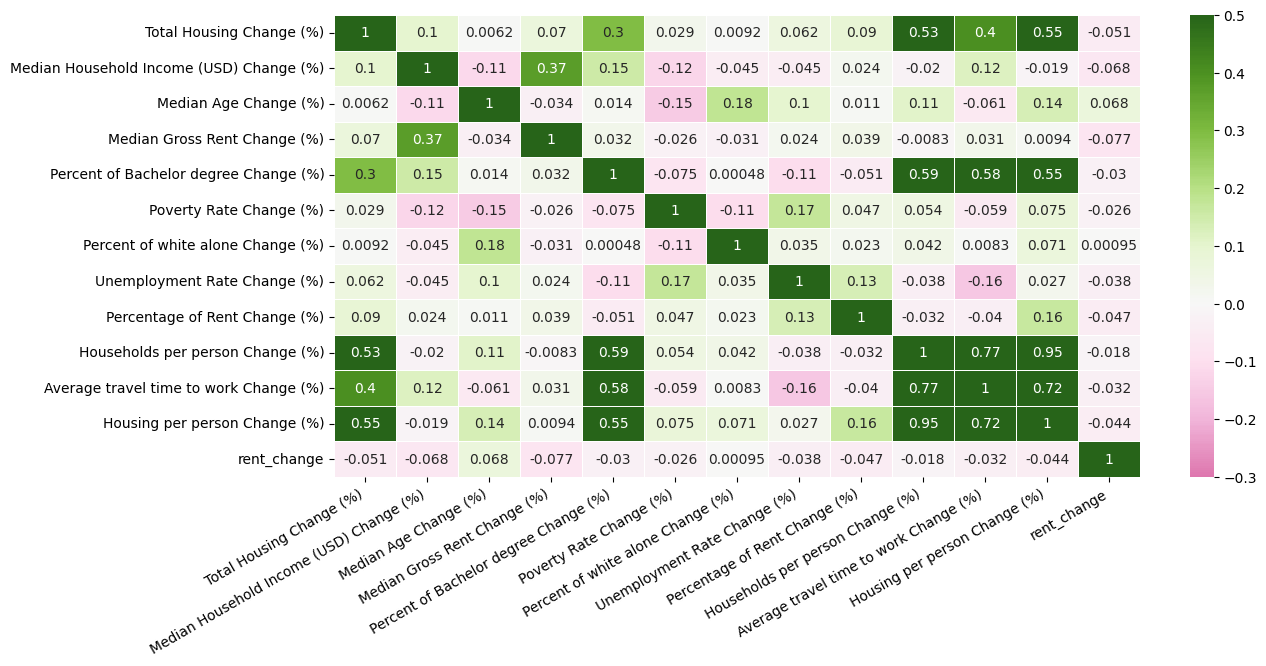

In [306]:
corrmat = merge_data[features+['rent_change']].corr()
plt.figure(figsize=(13, 6))
sns.heatmap(corrmat,vmax = 0.5, vmin = -0.3,  cmap="PiYG", annot=True, linewidths=.5, center=0, )
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()